# Clustering Orange

Dans cette première partie du TP, nous déterminerons le nombre de cluter, via différentes méthodes comme la méthode dite "du coude" ou du dendrogramme, pour classifier les individus dans les groupes les plus représentatifs. Ce notebook concerne l'utilisation des variables oranges.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from utils.utils import weighted_distance_matrix
from utils.utils import select_features

import warnings
warnings.filterwarnings("ignore")

In [2]:
fic_epita_kantar_codes = pd.read_csv('../data/fic_epita_kantar_codes.csv', sep=';')
fic_epita_kantar_codes

,cle,Respondent_ID,weight,A11,A12,A13,A14,A4,A5,A5bis,...,RS193,RS102RECAP,rs11recap2,RS11recap,RS193bis,RS2Recap,RS56Recap,RS2,RS11,RS102
0,1,MET20_999999996,2.501255,1,0,0,0,1,2.0,NaN,...,2,4,1,2,NaN,1,1,24,0,4
1,2,MET20_98888888,0.722914,1,0,0,0,1,5.0,NaN,...,2,1,1,2,NaN,4,1,50,0,1
2,3,MET20_1978307,1.039611,1,0,0,0,1,2.0,NaN,...,2,3,2,1,NaN,3,2,37,1,3
3,4,MET20_1302078,0.976590,1,1,1,0,1,1.0,NaN,...,2,2,1,2,NaN,5,3,63,0,2
4,5,MET20_1869308,0.812315,0,1,0,0,2,NaN,1.0,...,2,3,2,1,NaN,3,1,44,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,MET20_779605,0.905997,1,0,1,0,3,NaN,1.0,...,2,2,1,2,NaN,6,3,69,0,2
4996,4997,MET20_80000348,1.257884,0,1,0,0,2,NaN,1.0,...,2,1,1,2,NaN,4,3,53,0,1
4997,4998,MET20_288029,1.094695,0,1,0,0,2,NaN,2.0,...,1,2,1,2,2.0,6,3,75,0,2
4998,4999,MET20_1235808,2.022023,0,0,1,0,3,NaN,1.0,...,2,3,2,1,NaN,2,3,33,1,3


In [3]:
columns = [
    'A9_1_slice', 'A9_2_slice', 'A9_3_slice', 'A9_4_slice', 'A9_5_slice', 
    'A9_6_slice', 'A9_7_slice', 'A9_8_slice', 'A9_9_slice', 'A9_10_slice', 
    'A9_11_slice', 'A9_12_slice', 'A9_13_slice', 'A9_14_slice', 'A9_15_slice', 
    'A9_16_slice', 'A10_1_slice', 'A10_2_slice', 'A10_3_slice', 'A10_4_slice', 
    'A10_5_slice', 'A10_6_slice', 'A10_7_slice', 'A10_8_slice', 'A11_1_slice', 
    'A11_2_slice', 'A11_3_slice', 'A11_4_slice', 'A11_5_slice', 'A11_6_slice', 
    'A11_7_slice', 'A11_8_slice', 'A11_9_slice', 'A11_10_slice', 'A11_11_slice', 
    'A11_12_slice', 'A11_13_slice'
]

# On remplace les valeurs manquantes par 0 (car les valeurs manquantes sont des valeurs non cochées)
fic_epita_kantar_codes[columns] = fic_epita_kantar_codes[columns].fillna(0)

# On ne garde que les colonnes qui nous intéressent
fic_epita_kantar_codes = fic_epita_kantar_codes[['cle', 'Respondent_ID', 'weight'] + columns]
fic_epita_kantar_codes

,cle,Respondent_ID,weight,A9_1_slice,A9_2_slice,A9_3_slice,A9_4_slice,A9_5_slice,A9_6_slice,A9_7_slice,...,A11_4_slice,A11_5_slice,A11_6_slice,A11_7_slice,A11_8_slice,A11_9_slice,A11_10_slice,A11_11_slice,A11_12_slice,A11_13_slice
0,1,MET20_999999996,2.501255,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,2,MET20_98888888,0.722914,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
2,3,MET20_1978307,1.039611,3,2,2,2,3,2,2,...,2,2,2,2,2,2,2,2,2,2
3,4,MET20_1302078,0.976590,1,2,2,2,3,2,3,...,2,1,2,3,3,3,2,2,1,2
4,5,MET20_1869308,0.812315,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,MET20_779605,0.905997,3,2,3,4,3,2,2,...,2,1,2,1,1,1,1,1,1,1
4996,4997,MET20_80000348,1.257884,2,3,4,3,3,2,4,...,2,2,3,2,2,2,2,3,2,4
4997,4998,MET20_288029,1.094695,3,4,4,3,2,2,4,...,3,2,3,3,3,2,3,3,2,3
4998,4999,MET20_1235808,2.022023,3,3,4,3,3,2,3,...,3,3,2,3,2,3,2,2,1,3


## Choix du nombre de groupes

On effectue dans un premier temps des manipulations de formattage pour l'utilisation de la méthode du coude.

In [4]:
features = select_features(fic_epita_kantar_codes, columns)
features = features.values
features

array([[2, 2, 2, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [3, 2, 2, ..., 2, 2, 2],
       ...,
       [3, 4, 4, ..., 3, 2, 3],
       [3, 3, 4, ..., 2, 1, 3],
       [3, 3, 3, ..., 3, 2, 3]], dtype=int64)

On prend en compte les poids des différents individus dans le calcul des distances.

In [5]:
weights = fic_epita_kantar_codes['weight'].values

len(weights)

5000

In [6]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled[0]

array([-0.2640333 , -0.82857731, -0.76535321, -0.69281308, -0.82116736,
       -0.2763925 , -0.46616386, -0.49771748, -0.10796943, -0.48102038,
        0.08546965, -1.08720179, -0.84263013, -0.06409145, -0.33781819,
       -0.65054533,  0.386317  ,  0.28441199, -0.6139091 , -0.13282554,
        0.356308  , -0.87857118, -0.20681138, -0.40066784,  0.11494051,
        0.07519132,  0.160471  , -0.02949588,  0.14223603,  0.1858171 ,
        0.08752076, -0.13853922, -0.34101514,  0.032618  , -0.30186021,
        0.03040058, -0.18203054])

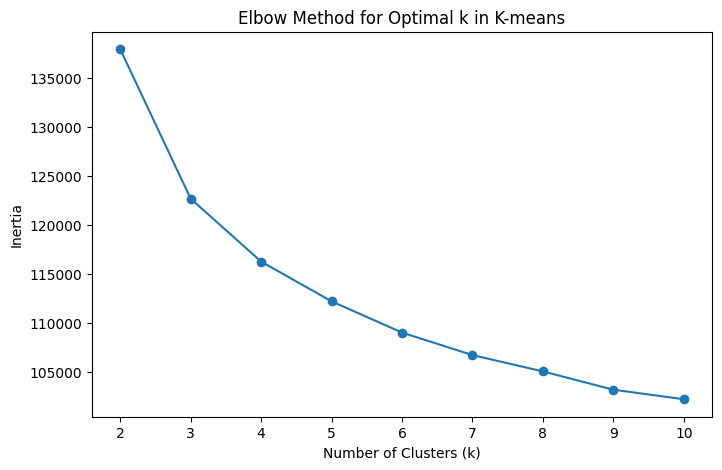

In [7]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled, sample_weight=weights)
    inertia.append(kmeans.inertia_)

# Affichage du graphique de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k in K-means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.show()

La méthode du coude ne donne ici pas de résultat clair concernant le nombre de clusters à définir.

On utilise ensuite la méthode du dendrogramme.

On définit pour ça la matrice de distances pondérée par les poids des individus.

In [8]:
weighted_distances = weighted_distance_matrix(features_scaled, weights)

# Conversion en format condensé pour linkage
condensed_weighted_distances = squareform(weighted_distances)

# Clustering hiérarchique avec la matrice de distances pondérées
Z = linkage(condensed_weighted_distances, method='ward')
Z

100%|██████████| 5000/5000 [01:19<00:00, 63.00it/s] 


array([[3.00000000e+02, 3.79300000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.22700000e+03, 2.60300000e+03, 0.00000000e+00, 2.00000000e+00],
       [2.77000000e+02, 4.41000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [9.99300000e+03, 9.99400000e+03, 1.48746014e+02, 1.14100000e+03],
       [9.99200000e+03, 9.99500000e+03, 1.80086864e+02, 3.85900000e+03],
       [9.99600000e+03, 9.99700000e+03, 2.79087602e+02, 5.00000000e+03]])

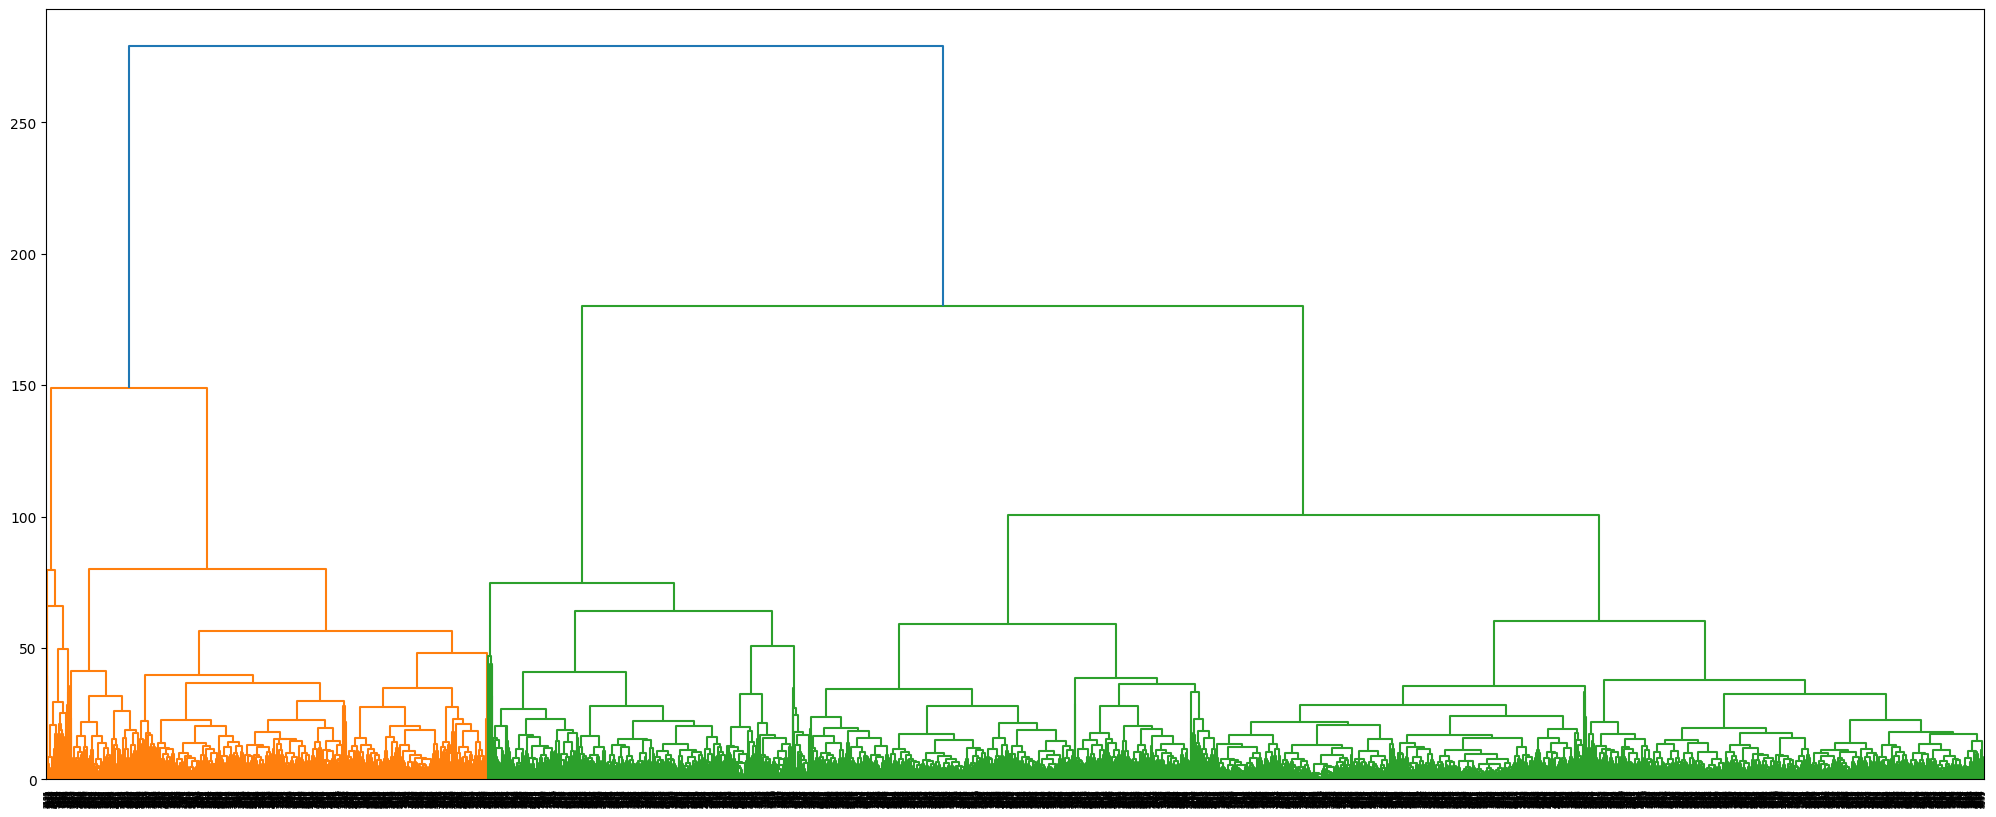

In [9]:
plt.figure(figsize=(25, 10))
dendrogram(Z, orientation='top')
plt.show()

Au vu de la figure présente, on choisit ici 4 clusters.

## K-means clustering

Il s'agit de la même méthode que précedemment; on prend en compte les distances pondérées pour le calcul des moyennes.

In [10]:
# On choisit 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features_scaled, sample_weight=weights)

# Ajout des labels dans le dataframe
fic_epita_kantar_codes['cluster'] = kmeans.labels_
fic_epita_kantar_codes

,cle,Respondent_ID,weight,A9_1_slice,A9_2_slice,A9_3_slice,A9_4_slice,A9_5_slice,A9_6_slice,A9_7_slice,...,A11_5_slice,A11_6_slice,A11_7_slice,A11_8_slice,A11_9_slice,A11_10_slice,A11_11_slice,A11_12_slice,A11_13_slice,cluster
0,1,MET20_999999996,2.501255,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,0
1,2,MET20_98888888,0.722914,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,3
2,3,MET20_1978307,1.039611,3,2,2,2,3,2,2,...,2,2,2,2,2,2,2,2,2,0
3,4,MET20_1302078,0.976590,1,2,2,2,3,2,3,...,1,2,3,3,3,2,2,1,2,0
4,5,MET20_1869308,0.812315,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,MET20_779605,0.905997,3,2,3,4,3,2,2,...,1,2,1,1,1,1,1,1,1,3
4996,4997,MET20_80000348,1.257884,2,3,4,3,3,2,4,...,2,3,2,2,2,2,3,2,4,1
4997,4998,MET20_288029,1.094695,3,4,4,3,2,2,4,...,2,3,3,3,2,3,3,2,3,1
4998,4999,MET20_1235808,2.022023,3,3,4,3,3,2,3,...,3,2,3,2,3,2,2,1,3,1


In [11]:
# Sauvegarde du df
fic_epita_kantar_codes.to_csv('../data/orange.csv', index=False)

## Informations générales sur les clusters

In [12]:
# On regarde la répartition des clusters
fic_epita_kantar_codes['cluster'].value_counts()

cluster
0    2039
1    1464
3    1128
2     369
Name: count, dtype: int64

In [13]:
# On regarde les moyennes des features par cluster
cluster_means = fic_epita_kantar_codes.groupby('cluster').mean(numeric_only=True)
cluster_means

,cle,weight,A9_1_slice,A9_2_slice,A9_3_slice,A9_4_slice,A9_5_slice,A9_6_slice,A9_7_slice,A9_8_slice,...,A11_4_slice,A11_5_slice,A11_6_slice,A11_7_slice,A11_8_slice,A11_9_slice,A11_10_slice,A11_11_slice,A11_12_slice,A11_13_slice
cluster,,,,,,,,,,,,,,,,,,,,,
0,2481.047572,0.969827,2.050025,2.534085,2.460520,2.404120,2.701815,2.187837,2.280039,2.223149,...,1.995586,1.831780,1.860226,1.870525,2.028445,2.201569,1.878372,2.130947,1.908288,2.044139
1,2516.032104,0.963660,2.663251,3.214481,3.226093,3.155738,2.726776,2.306694,3.111339,2.973361,...,2.321721,2.212432,2.079235,2.258197,2.511612,2.645492,2.351776,2.691940,2.303962,2.624317
2,2569.116531,1.048862,3.341463,3.699187,3.710027,3.734417,2.918699,2.926829,3.612466,3.612466,...,3.119241,3.211382,2.815718,3.249322,3.406504,3.447154,3.295393,3.474255,3.214092,3.455285
3,2493.057624,0.945594,1.539894,2.000000,1.951241,1.874113,2.518617,1.881206,1.690603,1.687057,...,1.327128,1.175532,1.274823,1.202128,1.311170,1.516844,1.230496,1.457447,1.269504,1.342199


In [14]:
# On regarde les variances intra-cluster
cluster_vars = fic_epita_kantar_codes.groupby('cluster').var(numeric_only=True)
cluster_vars

,cle,weight,A9_1_slice,A9_2_slice,A9_3_slice,A9_4_slice,A9_5_slice,A9_6_slice,A9_7_slice,A9_8_slice,...,A11_4_slice,A11_5_slice,A11_6_slice,A11_7_slice,A11_8_slice,A11_9_slice,A11_10_slice,A11_11_slice,A11_12_slice,A11_13_slice
cluster,,,,,,,,,,,,,,,,,,,,,
0,2.039699e+06,0.198644,0.284052,0.435418,0.426188,0.435233,0.563642,0.368527,0.771883,0.361858,...,0.363572,0.218499,0.342083,0.233473,0.272988,0.300370,0.212874,0.251245,0.275687,0.379798
1,2.075479e+06,0.157578,0.469571,0.379120,0.381520,0.404984,0.638900,0.490290,0.721020,0.429228,...,0.441196,0.302757,0.439377,0.339304,0.397678,0.398503,0.355322,0.441603,0.468720,0.555963
2,2.234021e+06,0.365116,0.491782,0.259809,0.228187,0.206448,0.884677,0.921262,0.444518,0.335822,...,0.659656,0.493240,0.851817,0.486582,0.372349,0.334836,0.502180,0.385884,0.576323,0.438892
3,2.128029e+06,0.152317,0.335585,0.580302,0.626724,0.559116,0.890514,0.619416,0.767542,0.433479,...,0.303718,0.153722,0.247387,0.179161,0.244702,0.377711,0.186398,0.308747,0.228989,0.344198


In [15]:
# On regarde les variances inter-cluster
inter_cluster_vars = cluster_means.var()
inter_cluster_vars

cle             1521.253398
weight             0.002094
A9_1_slice         0.605971
A9_2_slice         0.558566
A9_3_slice         0.613292
A9_4_slice         0.671141
A9_5_slice         0.026788
A9_6_slice         0.192766
A9_7_slice         0.731419
A9_8_slice         0.712554
A9_9_slice         0.426970
A9_10_slice        0.586661
A9_11_slice        0.706746
A9_12_slice        0.398174
A9_13_slice        0.543879
A9_14_slice        0.746392
A9_15_slice        0.563147
A9_16_slice        0.540451
A10_1_slice        0.371473
A10_2_slice        0.192704
A10_3_slice        0.047613
A10_4_slice        0.385923
A10_5_slice        0.370336
A10_6_slice        0.047732
A10_7_slice        0.416807
A10_8_slice        0.519166
A11_1_slice        0.587848
A11_2_slice        0.555838
A11_3_slice        0.673491
A11_4_slice        0.554394
A11_5_slice        0.724717
A11_6_slice        0.405623
A11_7_slice        0.732229
A11_8_slice        0.773275
A11_9_slice        0.655000
A11_10_slice       0

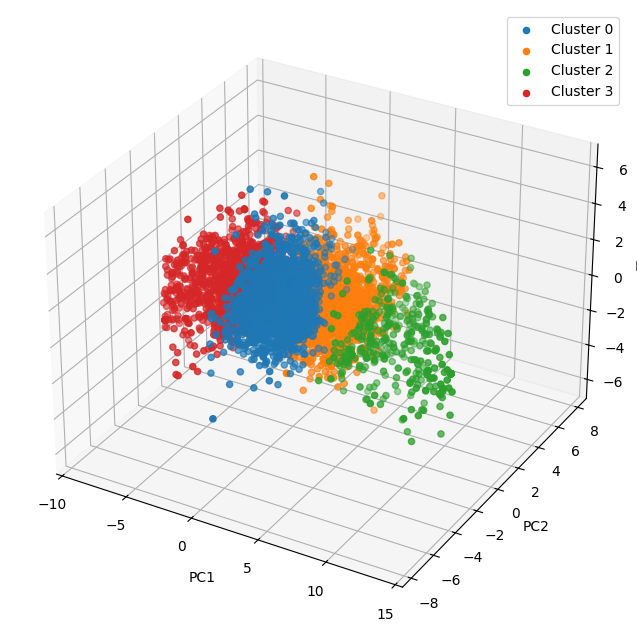

In [16]:
# Représentation en 3D dans l'espace des composantes principales
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(4):
    cluster_indices = fic_epita_kantar_codes[fic_epita_kantar_codes['cluster'] == cluster].index
    ax.scatter(features_pca[cluster_indices, 0], features_pca[cluster_indices, 1], features_pca[cluster_indices, 2], label=f'Cluster {cluster}')
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

On cherche ensuite à retrouver les composantes principales, pour l'explicabilité du graphe 3D précédent.

In [17]:
components = pd.DataFrame(pca.components_, columns=columns, index=['PC1', 'PC2', 'PC3'])

# Afficher les coefficients
display(components)

# Trouver les 3 features les plus importantes pour chaque composante
top_features_per_pc = components.apply(lambda row: row.abs().nlargest(3).index.tolist(), axis=1)

# Affichage des résultats
for pc, features in top_features_per_pc.items():
    print(f"{pc}: {', '.join(features)}")


,A9_1_slice,A9_2_slice,A9_3_slice,A9_4_slice,A9_5_slice,A9_6_slice,A9_7_slice,A9_8_slice,A9_9_slice,A9_10_slice,...,A11_4_slice,A11_5_slice,A11_6_slice,A11_7_slice,A11_8_slice,A11_9_slice,A11_10_slice,A11_11_slice,A11_12_slice,A11_13_slice
PC1,0.177909,0.170057,0.172720,0.176170,0.038071,0.095443,0.153264,0.184030,0.138516,0.171198,...,0.167606,0.199969,0.149465,0.197067,0.196668,0.182906,0.199193,0.192274,0.180557,0.182637
PC2,0.217004,0.282679,0.303319,0.282718,0.020671,-0.040342,0.051017,0.225561,0.077496,0.222978,...,-0.139584,-0.166950,-0.200108,-0.152942,-0.136421,-0.118632,-0.091337,-0.085644,-0.124872,-0.126204
PC3,-0.177379,-0.022327,0.001634,0.018567,0.324298,0.131739,0.340771,-0.078328,0.147323,-0.056715,...,-0.144154,-0.081350,-0.152574,-0.006185,-0.056328,0.085473,0.022660,0.153685,0.130416,0.245127


PC1: A11_5_slice, A11_10_slice, A11_7_slice
PC2: A9_3_slice, A9_4_slice, A9_2_slice
PC3: A10_8_slice, A10_3_slice, A9_7_slice


In [18]:
# Distribution des features principales par cluster
important_features = ['A11_5_slice', 'A11_10_slice', 'A11_7_slice']  # Exemple
cluster_analysis = fic_epita_kantar_codes.groupby('cluster')[important_features].mean(numeric_only=True)

display(cluster_analysis)

,A11_5_slice,A11_10_slice,A11_7_slice
cluster,,,
0,1.831780,1.878372,1.870525
1,2.212432,2.351776,2.258197
2,3.211382,3.295393,3.249322
3,1.175532,1.230496,1.202128


In [19]:
# Distribution des features principales par cluster
important_features = ['A9_3_slice', 'A9_4_slice', 'A9_2_slice']  # Exemple
cluster_analysis = fic_epita_kantar_codes.groupby('cluster')[important_features].mean(numeric_only=True)

display(cluster_analysis)

,A9_3_slice,A9_4_slice,A9_2_slice
cluster,,,
0,2.460520,2.404120,2.534085
1,3.226093,3.155738,3.214481
2,3.710027,3.734417,3.699187
3,1.951241,1.874113,2.000000


In [20]:
important_features = ['A10_8_slice', 'A10_3_slice', 'A9_7_slice']  # Exemple
cluster_analysis = fic_epita_kantar_codes.groupby('cluster')[important_features].mean(numeric_only=True)

display(cluster_analysis)

,A10_8_slice,A10_3_slice,A9_7_slice
cluster,,,
0,2.282491,2.422756,2.280039
1,2.806694,2.583333,3.111339
2,3.363144,2.701897,3.612466
3,1.678191,2.197695,1.690603
